In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
import h5py
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm import trange
from copy import deepcopy

### Getting Data

In [2]:
# train_data = pd.read_csv('mnist_train.csv')
# test_data = pd.read_csv('mnist_test.csv')

def load_hdf5_data(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        images = np.array(h5_file['image'])
        images = torch.tensor(images)
        labels = np.array(h5_file['label'])
        labels = torch.tensor(labels)    
    print("Images shape: ", images.shape) #, 'Images dtype: ', images.dtype)
    print("Labels shape: ", labels.shape) #, 'Labels dtype: ', labels.dtype)
    return images, labels

images, labels = load_hdf5_data('Indian_dataset_new.h5')

Images shape:  torch.Size([2762, 256, 256, 3])
Labels shape:  torch.Size([2762])


In [3]:
train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.2, random_state=0,stratify=labels)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

(torch.Size([2209, 256, 256, 3]),
 torch.Size([553, 256, 256, 3]),
 torch.Size([2209]),
 torch.Size([553]))

In [4]:
train_x_1 = train_x[train_y==1]
train_y_1 = train_y[train_y==1]
train_x_0 = train_x[train_y==0]
train_y_0 = train_y[train_y==0]

test_x_1 = test_x[test_y==1]
test_y_1 = test_y[test_y==1]
test_x_0 = test_x[test_y==0]
test_y_0 = test_y[test_y==0]

train_y_1.shape,train_y_0.shape,test_y_1.shape,test_y_0.shape

(torch.Size([609]), torch.Size([1600]), torch.Size([153]), torch.Size([400]))

In [5]:
# random 10 values from 0 to len(data_1_array)
random_values = np.random.randint(0, len(train_x_1), 10)

# train pool split
train_1, train_1_y = train_x_1[random_values], train_y_1[random_values]
pool_1, pool_1_y = np.delete(train_x_1, random_values, axis=0), np.delete(train_y_1, random_values, axis=0)

# random 10 values from 0 to len(data_0_array)
random_values = np.random.randint(0, len(train_x_0), 10)

# train pool split
train_0, train_0_y = train_x_0[random_values], train_y_0[random_values]
pool_0, pool_0_y = np.delete(train_x_0, random_values, axis=0), np.delete(train_y_0, random_values, axis=0)

In [6]:
pool_1.shape, train_1.shape, pool_0.shape, train_0.shape

(torch.Size([599, 256, 256, 3]),
 torch.Size([10, 256, 256, 3]),
 torch.Size([1590, 256, 256, 3]),
 torch.Size([10, 256, 256, 3]))

In [7]:
pool = torch.cat((pool_1, pool_0), axis=0)
pool_y = torch.cat((pool_1_y, pool_0_y), axis=0)

pool.shape, pool_y.shape

(torch.Size([2189, 256, 256, 3]), torch.Size([2189]))

In [8]:
class Model(nn.Module):
    feature_dim = 8

    def __init__(self,feature_dim=8,manual_seed=0):
        super().__init__()
        self.feature_dim = feature_dim
        torch.manual_seed(manual_seed)
        # print("Feature dim: ", self.feature_dim)
        self.conv1 = nn.Conv2d(3, 8, 5,stride=2)
        self.conv2 = nn.Conv2d(8, 16, 5,stride=2)
        self.conv3 = nn.Conv2d(16, feature_dim, 5,stride=2)
        self.fc1 = nn.Linear(feature_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.pool = nn.MaxPool2d(2, 2)
    
    def encoder(self,x):
        # gives features 
        x = x.view(-1, 3, 256, 256)             # [20, 3, 256, 256]
        x = self.pool(F.relu(self.conv1(x)))    # [20, 8, 63, 63]
        x = self.pool(F.relu(self.conv2(x)))    # [20, 16, 15, 15]
        x = self.pool(F.relu(self.conv3(x)))    # [20, 8, 3, 3]
        x = self.pool(x)                        # [20, 8, 1, 1]
        x = x.view(-1, self.feature_dim)             # [20, 8]
        return x 

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))                 # [20, 128]
        x = F.relu(self.fc2(x))                 # [20, 64]
        x = self.fc3(x)                         # [20, 1]
        return x

In [9]:
def metrics(pred,test_y):
    true_positives = torch.sum(torch.logical_and(pred == 1, test_y == 1)).item()
    true_negatives = torch.sum(torch.logical_and(pred == 0, test_y == 0)).item()
    false_positives = torch.sum(torch.logical_and(pred == 1, test_y == 0)).item()
    false_negatives = torch.sum(torch.logical_and(pred == 0, test_y == 1)).item()

    accuracy = (true_positives, true_negatives, false_positives, false_negatives)
    return accuracy


In [10]:
def train(model, optimizer, criterion, train_X, train_y, epochs=100):
    model.train()
    losses = []
    accuracy = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_X)
        # output = torch.cat((1 - output, output), 1)
        # print(output.shape, train_y.shape)
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pred = torch.round(output)
        accuracy.append(metrics(pred,train_y))
    
    accuracy = np.array(accuracy)

    return losses, accuracy, output

In [11]:
def eval(model, criterion, test_X, test_y):
    model.eval()
    with torch.no_grad():
        output = model(test_X)
        # output = torch.cat((1 - output, output), 1)
        loss = criterion(output, test_y)
        pred = torch.round(output)
        accuracy = metrics(pred,test_y)
        
    return loss.item(), accuracy, output

In [12]:
model = Model()
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [13]:
print(type(train_0))

<class 'torch.Tensor'>


In [14]:
train_X = torch.cat((train_0, train_1), axis=0).float()
train_y = torch.cat((train_0_y, train_1_y), axis=0).float()
train_y = train_y.unsqueeze(1)
# train_y = F.one_hot(train_y.to(torch.int64), num_classes=2).float()

train_X.shape, train_y.shape

(torch.Size([20, 256, 256, 3]), torch.Size([20, 1]))

In [15]:
losses, accuracy, pred = train(model, optimizer, criterion, train_X, train_y)

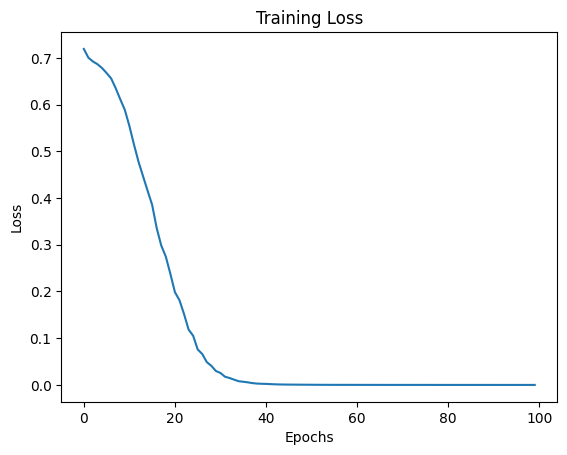

In [16]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

/var/folders/76/s25grzw958ld2_m4fhl5j5900000gn/T/ipykernel_12857/3472000055.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(100*(accuracy[:, 0]+accuracy[:, 1])/(accuracy[:, 0]+accuracy[:, 1]+accuracy[:, 2]+accuracy[:, 3]))


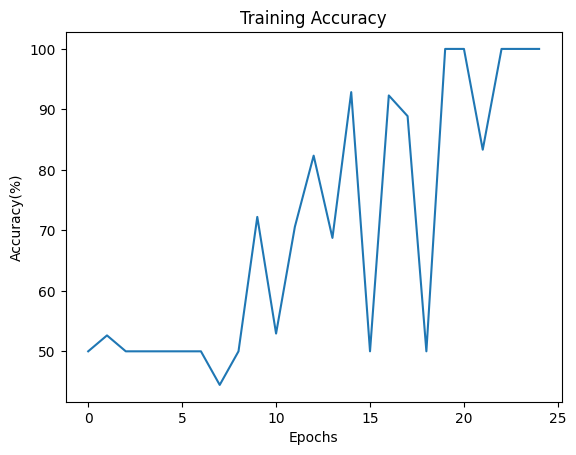

In [17]:
plt.plot(100*(accuracy[:, 0]+accuracy[:, 1])/(accuracy[:, 0]+accuracy[:, 1]+accuracy[:, 2]+accuracy[:, 3]))
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.title("Training Accuracy")
plt.show()

# Active Learning

In [18]:
def centroid(model, train_x, pool_x, pool_y, ranks=False):
    # features = model(train_x, features=True)
    features = model.encoder(train_x)
    centroid_feature = torch.mean(features, dim=0)
    # pool_features = model(pool_x, features=True)
    pool_features = model.encoder(pool_x)

    distance = torch.cdist(pool_features, centroid_feature.reshape(1, -1))
    
    n_max_idx = torch.argmax(distance)

    if ranks:
        distance_ranks = torch.argsort(distance.reshape(-1))

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], distance_ranks.reshape(-1)
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def farthest(model, train_x, pool_x, pool_y, ranks=False):
    # features = model(train_x, features=True)
    features = model.encoder(train_x)
    # pool_features = model(pool_x, features=True)
    pool_features = model.encoder(pool_x)
    distances = torch.cdist(pool_features, features)
    farthest = torch.max(distances, dim=1)
    n_max_idx = torch.argmax(farthest.values)

    if ranks:
        distance_ranks = torch.argsort(farthest.values)

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], distance_ranks.reshape(-1)
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def closest(model, train_x, pool_x, pool_y, ranks=False):
    # features = model(train_x, features=True)
    features = model.encoder(train_x)
    # pool_features = model(pool_x, features=True)
    pool_features = model.encoder(pool_x)
    distances = torch.cdist(pool_features, features)
    closest = torch.min(distances, dim=1)
    n_max_idx = torch.argmax(closest.values)

    if ranks:
        distance_ranks = torch.argsort(closest.values)

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], distance_ranks.reshape(-1)
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def entropy(model, pool_x, pool_y, ranks=False):
    p = model(pool_x)

    entropy = torch.where((p == 0) | (p == 1), torch.zeros_like(p), -p*torch.log2(p) - (1-p)*torch.log2(1-p)).reshape(-1)

    n_max_idx = torch.argmax(entropy)

    if ranks:
        entropy_ranks = torch.argsort(entropy)

        return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx], entropy_ranks
    
    return n_max_idx, pool_x[n_max_idx], pool_y[n_max_idx]


def compare_ranks(ranks1, ranks2):
    added = ranks1.reshape(-1) + ranks2.reshape(-1)

    min_rank, min_idx = torch.min(added, dim=0)

    return min_rank, min_idx

In [19]:
# test compare ranks
ranks1 = torch.tensor([10, 2, 3, 4, 5])
ranks2 = torch.tensor([5, 4, 3, 2, 1])

compare_ranks(ranks1, ranks2)

(tensor(6), tensor(1))

In [20]:
def test(model, criterion):
    test_X = torch.cat((test_x_0, test_x_1), axis=0).float()
    test_y = torch.cat((test_y_0, test_y_1), axis=0).float()
    test_y = test_y.unsqueeze(1)
    # test_y = F.one_hot(test_y.to(torch.int64), num_classes=2).float()

    loss, acc, _ = eval(model, criterion, test_X, test_y)

    return loss, acc

In [21]:
train_X = torch.cat((train_0, train_1), axis=0).float()
train_y = torch.cat((train_0_y, train_1_y), axis=0).float()
train_y = train_y.unsqueeze(1)
# train_y = F.one_hot(train_y.to(torch.int64), num_classes=2).float()

pool_X = torch.cat((pool_0, pool_1), axis=0).float()
pool_y = torch.cat((pool_0_y, pool_1_y), axis=0).float()
pool_y = pool_y.unsqueeze(1)
test_y = test_y.unsqueeze(1)
# pool_y = F.one_hot(pool_y.to(torch.int64), num_classes=2).float()
train_X.shape, train_y.shape, pool_X.shape, pool_y.shape,test_y.shape

(torch.Size([20, 256, 256, 3]),
 torch.Size([20, 1]),
 torch.Size([2189, 256, 256, 3]),
 torch.Size([2189, 1]),
 torch.Size([553, 1]))

In [22]:
losses = [[], [], []]
accuracy = [[], [], []]
ac_f = {1: centroid, 2: farthest, 3: closest}

In [23]:
for i in range(3):
    print(f"Active Learning Method: {i+1} ------------------------------")
    f = ac_f[i+1]

    model = Model()
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    t_x = deepcopy(train_X)
    t_y = deepcopy(train_y)
    p_x = deepcopy(pool_X)
    p_y = deepcopy(pool_y)
    
    for j in trange(10):
        _, _, _ = train(model, optimizer, criterion, t_x, t_y)
        loss, acc = test(model, criterion)

        losses[i].append(loss)
        accuracy[i].append(100*(acc[0]+acc[1])/(acc[0] + acc[1] + acc[2] + acc[3]))

        _, _, _, ranks1 = f(model, t_x, p_x, p_y, ranks=True)
        _, _, _, ranks2 = entropy(model, p_x, p_y, ranks=True)

        min_rank, ind = compare_ranks(ranks1, ranks2)

        t_x = torch.cat((t_x, p_x[ind].reshape(-1, 256, 256,3)), dim=0)
        t_y = torch.cat((t_y, p_y[ind].reshape(-1, 1)), dim=0)


        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)

        # print(f"Epoch {j+1} - Loss: {losses[i][-1]} - Accuracy: {accuracy[i][-1]}%")

Active Learning Method: 1 ------------------------------


100%|██████████| 10/10 [07:29<00:00, 44.98s/it]


Active Learning Method: 2 ------------------------------


100%|██████████| 10/10 [06:39<00:00, 39.97s/it]


Active Learning Method: 3 ------------------------------


100%|██████████| 10/10 [06:38<00:00, 39.87s/it]


In [24]:
random_losses = []
random_accuracy = []
manuel_seed = 0

In [26]:
seed = 0
for i in range(10):
    torch.manual_seed(seed)
    r_losses = []
    r_accuracy = []
    print(f"Random {i+1} ------------------------------")

    model = Model(manual_seed=seed)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    t_x = deepcopy(train_X)
    t_y = deepcopy(train_y)
    p_x = deepcopy(pool_X)
    p_y = deepcopy(pool_y)

    for j in trange(10):
        _, _, _ = train(model, optimizer, criterion, t_x, t_y)
        loss, acc = test(model, criterion)

        r_losses.append(loss)
        r_accuracy.append(100*(acc[0]+acc[1])/(acc[0] + acc[1] + acc[2] + acc[3]))
        
        ind = torch.randint(0, len(p_x),(1,)).item()

        t_x = torch.cat((t_x, p_x[ind].reshape(-1, 256, 256,3)), dim=0)
        t_y = torch.cat((t_y, p_y[ind].reshape(-1, 1)), dim=0)

        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)

        # print(f"Epoch {j+1} - Loss: {r_losses[-1]} - Accuracy: {r_accuracy[-1]}%")

    random_losses.append(r_losses)
    random_accuracy.append(r_accuracy)
    seed += 10

Random 1 ------------------------------


100%|██████████| 10/10 [03:02<00:00, 18.30s/it]


Random 2 ------------------------------


100%|██████████| 10/10 [03:04<00:00, 18.46s/it]


Random 3 ------------------------------


100%|██████████| 10/10 [03:04<00:00, 18.44s/it]


Random 4 ------------------------------


100%|██████████| 10/10 [03:45<00:00, 22.58s/it]


Random 5 ------------------------------


100%|██████████| 10/10 [03:03<00:00, 18.39s/it]


Random 6 ------------------------------


100%|██████████| 10/10 [03:04<00:00, 18.44s/it]


Random 7 ------------------------------


100%|██████████| 10/10 [03:08<00:00, 18.82s/it]


Random 8 ------------------------------


100%|██████████| 10/10 [03:03<00:00, 18.32s/it]


Random 9 ------------------------------


 70%|███████   | 7/10 [02:03<00:55, 18.39s/it]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses[0], label="Centroid")
plt.plot(losses[1], label="Farthest")
plt.plot(losses[2], label="Closest")
plt.plot(np.mean(random_losses, axis=0), label="Random")
plt.fill_between(np.arange(10), np.mean(random_losses, axis=0) - 1.645*np.std(random_losses, axis=0), np.mean(random_losses, axis=0) + 1.645*np.std(random_losses, axis=0), alpha=0.3)
plt.xlabel("No.of Iterations")
plt.ylabel("Loss")
plt.title("Training Loss over #iterations")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(random_losses[i], label=f"Random {i+1}")
plt.xlabel("No.of Iterations")
plt.ylabel("Loss")
plt.title("Training Loss over #iterations")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy[0], label="Centroid")
plt.plot(accuracy[1], label="Farthest")
plt.plot(accuracy[2], label="Closest")
plt.plot(np.mean(random_accuracy, axis=0), label="Random")
plt.fill_between(np.arange(10), np.mean(random_accuracy, axis=0) - 1.645*np.std(random_accuracy, axis=0), np.mean(random_accuracy, axis=0) + 1.645*np.std(random_accuracy, axis=0), alpha=0.3)
plt.xlabel("No.of Iterations")
plt.ylabel("Accuracy(%)")
plt.title("Test Accuracy over #iterations")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(random_accuracy[i], label=f"Random {i+1}")
plt.xlabel("No.of Iterations")
plt.ylabel("Loss")
plt.title("Test Accuracy over #iterations")
plt.legend()
plt.show()

In [ ]:
# testing seed
seed=0
for i in range(2):
    torch.manual_seed(seed)
    for j in range(2):
        ind = torch.randint(0, len(p_x),(1,)).item()
        print(ind)
    seed += 10